#

## Instalando Dependencias 

In [64]:
# Instalação das dependências
%pip install -r requirements.txt
!python -m spacy download pt_core_news_sm

     ---------------------------------------- 0.0/13.0 MB ? eta -:--:--
      --------------------------------------- 0.3/13.0 MB ? eta -:--:--
      --------------------------------------- 0.3/13.0 MB ? eta -:--:--
     - ------------------------------------- 0.5/13.0 MB 747.1 kB/s eta 0:00:17
     - ------------------------------------- 0.5/13.0 MB 747.1 kB/s eta 0:00:17
     - ------------------------------------- 0.5/13.0 MB 747.1 kB/s eta 0:00:17
     -- ------------------------------------ 0.8/13.0 MB 564.3 kB/s eta 0:00:22
     --- ----------------------------------- 1.0/13.0 MB 655.2 kB/s eta 0:00:19
     --- ----------------------------------- 1.3/13.0 MB 738.9 kB/s eta 0:00:16
     ---- ---------------------------------- 1.6/13.0 MB 801.5 kB/s eta 0:00:15
     ---- ---------------------------------- 1.6/13.0 MB 801.5 kB/s eta 0:00:15
     ----- --------------------------------- 1.8/13.0 MB 810.2 kB/s eta 0:00:14
     ----- --------------------------------- 1.8/13.0 MB 810.2 k

## Inserindo PDF no Script

In [65]:
import pdfplumber 
def pdfRead(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        text = ''
        for page in pdf.pages:
            text += page.extract_text() + '\n'
    return text

pdf_path = 'O-Alquimista-H.P.-Lovecraft.pdf'
pdf_text = pdfRead(pdf_path)

print(f"[INFO] Text Size in Characters: {len(pdf_text)}") # Contagem de caracteres contando espaços

[INFO] Text Size in Characters: 22331


## Adicionando Stopwords do NLTK e Custom Stopwords

In [66]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords') 

stop_words =  set(stopwords.words('portuguese'))
custom_stopwords = { 'de','a', 'do' ,'da', 'e','deles','delas','com' }

used_stop_words = stop_words.union(custom_stopwords) if custom_stopwords else stop_words

print(f'[INFO] Total stopwords: {len(used_stop_words)}')
print(used_stop_words)

[INFO] Total stopwords: 207
{'tem', 'aos', 'esse', 'minha', 'teremos', 'por', 'forem', 'essas', 'terá', 'houvermos', 'houvesse', 'também', 'eu', 'for', 'pelos', 'fossem', 'tivéramos', 'estamos', 'esta', 'pela', 'qual', 'nossas', 'tivemos', 'uma', 'ao', 'houveríamos', 'sua', 'hão', 'teus', 'aquilo', 'estejam', 'de', 'houveria', 'seríamos', 'vos', 'esteja', 'as', 'sou', 'houveremos', 'a', 'houverão', 'isso', 'quando', 'estivermos', 'houverem', 'tua', 'teve', 'os', 'estão', 'seriam', 'teriam', 'tinham', 'houverei', 'estiver', 'como', 'estivera', 'muito', 'formos', 'somos', 'das', 'pelo', 'numa', 'vocês', 'era', 'estivesse', 'seremos', 'minhas', 'estiverem', 'estou', 'são', 'e', 'estas', 'fomos', 'do', 'terei', 'houver', 'lhes', 'tivessem', 'até', 'mais', 'me', 'fôssemos', 'será', 'essa', 'tivermos', 'houvemos', 'num', 'estivéramos', 'mesmo', 'tenham', 'mas', 'você', 'ser', 'estávamos', 'estivéssemos', 'estejamos', 'haja', 'hajam', 'éramos', 'meu', 'suas', 'teu', 'está', 'temos', 'esteve',

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Diurno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Tratamento PLN usando Spacy e Regex

In [67]:
import re 
import spacy

nlp = spacy.load('pt_core_news_sm')

def preprocess_text(text, print_tokens = False):
    url_regex = r'https?://\S+|www\.\S+|\S+\.(com|org|net|br|gov|edu)\S*'
    text = re.sub(url_regex, ' ', text)

    text = text.lower()
    text = re.sub(r'\s+', ' ', text) 
    text = re.sub(r'[^a-zà-ú0-9 .,]', ' ', text) 
    
    doc  = nlp(text)

    tokens = [token.text for token in doc]

    # O PDF é literário 
    # Portanto, a lematização é preferida para preservar o significado das palavras
    # Já que no PDF dado contexto se mostra importante, stemming ia perder muito significado
    cleaned_tokens = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_punct]

    if print_tokens:
        print(f'[INFO] Original tokens [10]: {tokens[:10]}')
        print(f'[INFO] Lemmatized tokens [10]: {cleaned_tokens[:10]}')

    final_text = ' '.join(cleaned_tokens)
    return final_text

preprocessed_text = preprocess_text(pdf_text, True)

print(f'[INFO] Original text length: {len(pdf_text)}')
print(f'[INFO] Preprocessed text length: {len(preprocessed_text)}')

print(preprocessed_text[:500]) 


[INFO] Original tokens [10]: ['  ', 'o', 'alquimista', '   ', 'h.p', '.', 'lovecraft', 'tradução', ' ', 'renato']
[INFO] Lemmatized tokens [10]: ['  ', 'alquimista', '   ', 'h.p', 'lovecraft', 'tradução', ' ', 'Renato', 'suttano', 'renato']
[INFO] Original text length: 22331
[INFO] Preprocessed text length: 15340
   alquimista     h.p lovecraft tradução   Renato suttano renato suttano   Renato suttano doutor letra professor Faculdade Educação universidade federal grande dourar autor visita fantasma noite   poesia 2002 João cabral melo neto   poeta voz modernidade   ensaio 2005 bicho   poesia 2005 fim verão   poesia 2009   poética deslimite   poema imagem obra Manoel barro   ensaio 2009 além outro publicar Internet suttana manter site web contato tradutor poder fazer email   alquimista n alto coroar topo 


## Chunking Recursivo no PDF usando Text Splitter do LangChain

In [68]:
from langchain_text_splitters import RecursiveCharacterTextSplitter


# Valores ajustados de acordo com testes, valores são dados em quantidade de caracteres.
chunk_size = 1500
chunk_overlap = 150

# Utilizando Chunking Recursivo para melhor divisão do texto já que o texto é um livro
# e contem várias seções, capítulos e parágrafos, sendo organizado hierarquicamente

# Um chunking fixo, poderia cortar introduções de parágrafos e capitulos de forma inadequada.
# (Um chunking fixo no exemplo atual funcionaria razoavelmente bem mas prefiro usar o recursivo de exemplo)
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""], # Separa em Paragrafos, Linhas, palavras e em caracteres.
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
)

text_chunks = text_splitter.split_text(preprocessed_text)

print(f'[INFO] Number of text chunks: {len(text_chunks)}')
print(f'[INFO] First text chunk: {text_chunks[0]}')

[INFO] Number of text chunks: 12
[INFO] First text chunk: alquimista     h.p lovecraft tradução   Renato suttano renato suttano   Renato suttano doutor letra professor Faculdade Educação universidade federal grande dourar autor visita fantasma noite   poesia 2002 João cabral melo neto   poeta voz modernidade   ensaio 2005 bicho   poesia 2005 fim verão   poesia 2009   poética deslimite   poema imagem obra Manoel barro   ensaio 2009 além outro publicar Internet suttana manter site web contato tradutor poder fazer email   alquimista n alto coroar topo gramar morro cujo flanco próximo base guarnecir árvore galho retorcir floresta primeva situar velho chateau ancestral durante século ameia altíssimo ter vigiar paisagem selvagem irregular volta servir lar refúgio casa altivo cujo honorável linhagem velho muralha castelo musgo recobre torr antigo batir durante geração inteiro tempestade pouco ir ceder lento incoercível pressão tempo compor época feudalismo temido formidável fortaleza todo Fra

## Inserção dos Chunks e Embeddings no ChromaDB

In [69]:
from sentence_transformers import SentenceTransformer
import chromadb 

client = chromadb.Client()
# É melhor utilizado sem lemmatização ou stemming e sem remoção de acentos, modelo foi treinado com acentos e sem lemas.
model_name = 'all-MiniLM-L6-v2' 

model = SentenceTransformer(
    model_name
)
print("[INFO] Encoding Chunks")
embeddings = model.encode(text_chunks, show_progress_bar=True)

ids = [f'chunk_{i}' for i in range(len(text_chunks))]
collection_name = 'pdf_chunks'

if collection_name in [col.name for col in client.list_collections()]:
    print(f"[INFO] Deleting the existing collection '{collection_name}' ")
    client.delete_collection(name=collection_name)
    print(f"[SUCESS] Deleted the collection '{collection_name}' ")


collection = client.create_collection(name=collection_name)


collection.add(
    ids=ids,
    documents=text_chunks,
    embeddings=embeddings.tolist()
)
    

[INFO] Encoding Chunks


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

[INFO] Deleting the existing collection 'pdf_chunks' 
[SUCESS] Deleted the collection 'pdf_chunks' 


## Query de Exemplo ao Banco e Plotting de Distancia de Resultados

[INFO] Embedding Query


Batches: 100%|██████████| 1/1 [00:00<00:00, 126.79it/s]

[INFO] Best result for query: 'Quem é Renato Suttana?'
[INFO] Result: alquimista     h.p lovecraft tradução   Renato suttano renato suttano   Renato suttano doutor letra professor Faculdade Educação universidade federal grande dourar autor visita fantasma noite   poesia 2002 João cabral melo neto   poeta voz modernidade   ensaio 2005 bicho   poesia 2005 fim verão   poesia 2009   poética deslimite   poema imagem obra Manoel barro   ensaio 2009 além outro publicar Internet suttana manter site web contato tradutor poder fazer email   alquimista n alto coroar topo gra... 
distance: 1.4269



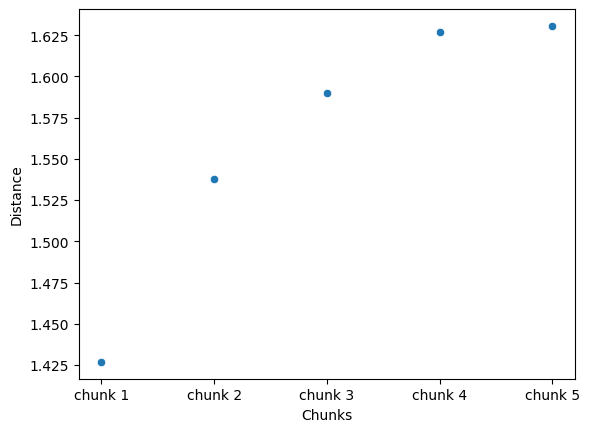

In [70]:
import seaborn as sb 
import matplotlib.pyplot as plt
raw_query = "Quem é Renato Suttana?"
query = preprocess_text(raw_query)
print("[INFO] Embedding Query")
query_embedding = model.encode([query], show_progress_bar=True)

results = collection.query(query_embeddings=query_embedding.tolist(), n_results=5, include=['documents','distances'])

# Melhor Resultado da Query e sua distancia 

# A Query não dá diretamente a resposta, mas traz o chunk mais relevante, 
# no caso uma resposta mais "precisa" seria realizada se o chunk fosse menor 
# ou se o contexto fosse passado para uma IA de linguagem natural, onde ela utilizaria de contexto

print(f"[INFO] Best result for query: '{raw_query}'")
print(f"[INFO] Result: {results['documents'][0][0][:500]}...",f"\ndistance: {results['distances'][0][0]:.4f}\n")

# Plot para visualizar as distâncias dos chunks retornados
# A Distancia é a distância do embedding da query para o embedding do chunk, quanto mais próximo de 0, 
# mais relevante o chunk é a query, no caso do modelo utilizado (all-MiniLM-L6-v2) 
# a distancia é calculada via cosseno

sb.scatterplot(x=[f'chunk {i+1}' for i in range(len(results['distances'][0]))], y=results['distances'][0])
plt.ylabel('Distance')
plt.xlabel('Chunks')
plt.show()

In [71]:
import pandas as pd
data = {
    'Chunk': [f'chunk {i+1}' for i in range(len(results['distances'][0]))],
    'Distance': results['distances'][0],
    'Document': results['documents'][0]
}
df = pd.DataFrame(data)
print("[INFO] TOP 5 Results for the Query")
print(df)

[INFO] TOP 5 Results for the Query
     Chunk  Distance                                           Document
0  chunk 1  1.426884  alquimista     h.p lovecraft tradução   Renato...
1  chunk 2  1.538067  olhar repente resto animar último ímpeto força...
2  chunk 3  1.589918  encontrar câmara distante pouco utilizar grand...
3  chunk 4  1.627227  piso destruír lambri carcomir tapeçaria gasto ...
4  chunk 5  1.630613  longo século   henri robert antoine armands to...
